# Figure 7
Responses measured in tunnels of 100 m and 200 m in length, using offsets of (a) 0 m; (b) 5 m; (c) 10 m; (d) 20m; (e) 30 m; (f) 50 m

In [ ]:
from SimPEG import  maps, utils
import SimPEG.electromagnetics.time_domain as tdem
from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, active_from_xyz
import empymod
import numpy as np
from scipy.constants import mu_0
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib import animation, collections

try:
    from pymatsolver import Pardiso as Solver
except:
    from SimPEG import SolverLU as Solver

import sys

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('bmh')

/tmp/ipykernel_10246/2016789560.py:1: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG import  maps, utils


In [2]:
# setting the loop location
def get_loop_location(length, angle, offset):

    """
    Get the loop location based on the length and angle
    """
    delta = offset / 2
    locations = []

    # if angle < 90:
    x = length / 2
    y = (length / 2) * np.sin(np.deg2rad(angle))
    z = (length / 2) * np.cos(np.deg2rad(angle))

    locations.append([-delta-x, -y,  z])
    locations.append([-delta+x, -y,  z])
    locations.append([-delta+x,  y, -z])
    locations.append([-delta-x,  y, -z])
    locations.append([-delta-x, -y,  z])

    return np.array(locations)


In [3]:
def mesh_d(offset, cell, tunnel_length, length, angle, dir):
    delta = offset / 2
    dh = cell  # base cell width
    # dom_width = 5000.0  # domain width
    dom_width = 10000
    nbc = 2 ** int(np.round(np.log(dom_width / dh) / np.log(2.0)))  # num. base cells

    # Define the base mesh
    h = [(dh, nbc)]
    mesh = TreeMesh([h, h, h], x0="CCC")
    n = tunnel_length / 2
    for i in range(int(tunnel_length)):
        x_low = -n + i + 0.1 
        # ——————————————————————————y-left——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [-2.5, -2.3], [-2.5, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        # ——————————————————————————y-right——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [2.4, 2.6], [-2.5, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

        # ——————————————————————————z-upper——————————————————————————————————
        xp, yp, zp = np.meshgrid([x_low], [-2.5, 2.5], [2.4, 2.5])
        xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
        mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————z-lower——————————————————————————————————
    xp, yp, zp = np.meshgrid([-n, n], [-0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    xp, yp, zp = np.meshgrid([-n, n], [0.7], [-2.4, -2.3])
    xyz = np.c_[mkvc(xp), mkvc(yp), mkvc(zp)]
    mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2], method="box", finalize=False)

    # # ——————————————————————————接收点加密——————————————————————————————————
    # xp, yp, zp = np.meshgrid([0.0, 0.5], [0, 0], [0, 0])
    receiver_locations = np.array([[delta, 0, 0]])

    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, receiver_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    if angle <= 180 and angle >= 0:
        source_locations = get_loop_location(length, angle, offset)
    else:
        print('Angle should be between 0 and 180')
        return

    mesh = refine_tree_xyz(
        mesh, source_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    # # ——————————————————————————异常体区域加密——————————————————————————————————
    if dir == 1:
        x1, y1, z1 = 0, 75, 0
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 2:
        x1, y1, z1 = 0, 75, 75
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 3:
        x1, y1, z1 = 0, 0, 75
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 4:
        x1, y1, z1 = 0, -75, 75
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    elif dir == 5:
        x1, y1, z1 = 0, -75, 0
        abnormal_locations = np.array(
            [[x1, y1, z1], 
            [x1-25, y1-25, z1+25], [x1-25, y1-25, z1-25], 
            [x1+25, y1-25, z1+25], [x1+25, y1-25, z1-25],
            [x1-25, y1+25, z1+25], [x1-25, y1+25, z1-25], 
            [x1+25, y1+25, z1+25], [x1+25, y1+25, z1-25]])
    else:
        print('error')
        return 0
    # Mesh refinement near transmitters and receivers
    mesh = refine_tree_xyz(
        mesh, abnormal_locations, octree_levels=[2, 4], method="radial", finalize=False
    )

    mesh.finalize()

    return mesh, source_locations, receiver_locations, abnormal_locations[0]

In [4]:
def get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block, sigma_air, center, tunnel_length):
    thickness = 0.2

    model = np.ones(mesh.nC) * sigma_half
    mur = np.ones(mesh.nC)

    n = int(tunnel_length/2)
    ################layer####################
    layer = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))

    rail1 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= -0.8) & (mesh.gridCC[:,1] <= -0.8 + thickness) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))

    rail2 = ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
            (mesh.gridCC[:,1] >= 0.8 - thickness) & (mesh.gridCC[:,1] <= 0.8) &
            (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= -2.5 + thickness))
    model[layer] = sigma_air
    mur[layer] = 1  


    ################ interference ####################
    for i in range(int(tunnel_length)):
        layer_1 =   ((mesh.gridCC[:,0] >= -n+i) & (mesh.gridCC[:,0] <= -n+i+thickness) & 
                    (mesh.gridCC[:,1] >= -2.5) & (mesh.gridCC[:,1] <= 2.5) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5))
        
        model[layer_1] = sigma_frame
        mur[layer_1] = mu_r


    layer_2 =   ((mesh.gridCC[:,0] >= -n) & (mesh.gridCC[:,0] <= n) & 
                    (mesh.gridCC[:,1] >= -2.5 + thickness) & (mesh.gridCC[:,1] <= 2.5 - thickness) &
                    (mesh.gridCC[:,2] >= -2.5) & (mesh.gridCC[:,2] <= 2.5 - thickness))
    model[layer_2] = sigma_air
    mur[layer_2] = 1


    model[rail1] = sigma_rail
    model[rail2] = sigma_rail
    mur[rail1] = mu_r
    mur[rail2] = mu_r
    
    ################ abnormal ####################
    block = (
        (mesh.gridCC[:,0] >= center[0]-25) & (mesh.gridCC[:,0] <= center[0]+25) & 
        (mesh.gridCC[:,1] >= center[1]-25) & (mesh.gridCC[:,1] <= center[1]+25) & 
        (mesh.gridCC[:,2] >= center[2]-25) & (mesh.gridCC[:,2] <= center[2]+25))
    model[block] = sigma_block

#     fig = plt.figure(figsize=(10,10), dpi=100)
#     plt.subplot(221)
#     plt.rcParams["font.family"] = ["Times New Roman"]
#     ax = plt.gca()
#     # mesh.plot_3d_slicer(np.log10(model), zslice = 0, fig=fig, 
#     #                     xlim=[-10, 10], ylim=[-10, 10], zlim=[-10, 10],
#     #                     )
#     dat2 = mesh.plotSlice(np.log10(model), grid= True , ax=ax, normal='x',lw=0.5)
# #     ax.grid(linewidth=2)  # 设置网格线的粗细为2
# #     ax.set_xlim([-100,100])
# #     ax.set_ylim([-100,100])
#     ax.set_xlim([-3,3])
#     ax.set_ylim([-3,3])
#     ax.set_title("Conductivity profile at X = 0")
#     ax.set_xlabel("Y / m", fontsize=12)
#     ax.set_ylabel("Z / m", fontsize=12)
#     ax.tick_params(labelsize=12)

#     plt.subplot(222)
#     ax = plt.gca()
#     dat2 = mesh.plotSlice(np.log10(model), grid= False , ax=ax,  normal='y')
#     ax.set_xlim([-50,50])
#     ax.set_ylim([-3,3])
#     ax.set_title("Conductivity profile at Y = 0")
#     ax.set_xlabel("X / m", fontsize=12)
#     ax.set_ylabel("Z / m", fontsize=12)
#     ax.tick_params(labelsize=12)

    return model, mur

In [5]:
def forward(mesh, model, mur, source_locations, receiver_locations,  path):
    times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)
    rec_list = []
    for i in ["x", "y", "z"]:
        rec_list.append(tdem.Rx.PointMagneticFluxTimeDerivative(
                    orientation = i,
                    times=times,
                    locations=receiver_locations[0])
                    )

    # Set up the source list
    src_list = [
        tdem.Src.LineCurrent(
            receiver_list=rec_list,
            location=source_locations,
        ),
    ]

    # Create `Survey`
    survey = tdem.Survey(src_list)

    # time_steps = [1e-1, (1e-2, 21), (3e-2, 23), (1e-1, 21), (3e-1, 23)]
    time_steps =  [1e-7, (1e-7,21), (3e-7,21), (1e-6,21), (3e-6,21), (1e-5, 21), (3e-5, 21),(1e-4, 21), (3e-4, 21),(1e-3, 21)]
    # Define the `Simulation`
    prob = tdem.Simulation3DElectricField(
        mesh,
        survey=survey,
        sigmaMap=maps.IdentityMap(mesh),
        solver=Solver,
        time_steps=time_steps,
        verbose = True
    )

    # Run the forward simulation
    prob.mu = mur*mu_0
    dpred = prob.dpred(model)

    np.save(path, dpred)
    
    return 0
    # np.save("./data_offset/dobs_offset{}m_noBlock.npy".format(d),dpred)

### 计算有干扰时的响应

In [6]:
def effective_conductivity(sigma_steel, sigma_back, S_steel, S_cell):
    #sigma_real * A_real / A_eff
    sigma_eff = sigma_steel * (S_steel / S_cell) + sigma_back * (S_cell - S_steel) / S_cell
    return sigma_eff

In [7]:
sigma_half = round(1 / 300, 4)
sigma_steel = 5e6
sigma_tunnel = 1e-8
sigma_block = [sigma_half, 1]

cell = [0.05]
tunnel_length = [100, 200]

mu_r = 100
sigma_frame = effective_conductivity(sigma_steel, sigma_tunnel, 21.5e-4, pow(4*cell[0], 2))
sigma_rail  = effective_conductivity(sigma_steel, sigma_tunnel, 50.8e-4, pow(4*cell[0], 2))

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2, 3, 4, 5]   # 异常体的方位
angle = [0, 30, 45, 60, 90, 120, 150, 180]
length = 1  # 线圈边长

for k in range(len(tunnel_length)):
    for i in range(len(sigma_block)):
        for j in range(len(offset)):
            path = "./data_fig7/data_block{}_offset{}_dir{}_angle{}_tunnel{}m.npy".format(sigma_block[i], offset[j], dir[0], angle[0], tunnel_length[k])
            mesh, source_locations, receiver_locations, center = mesh_d(offset[j], cell[0], tunnel_length[k], length, angle[0], dir[0])
            model, mur = get_model_frame_rail(mesh, sigma_half, sigma_frame, sigma_rail, mu_r, sigma_block[i], sigma_tunnel, center, tunnel_length[k])
            forward(mesh, model, mur, source_locations, receiver_locations, path)

Calculating Initial fields
Factoring the system matrix for the DC problem
**************************************************
Calculating fields(m)
**************************************************
Factoring...   (dt = 1.000000e-07)
Done
    Solving...   (tInd = 1)
    Done...
    Solving...   (tInd = 2)
    Done...
    Solving...   (tInd = 3)
    Done...
    Solving...   (tInd = 4)
    Done...
    Solving...   (tInd = 5)
    Done...
    Solving...   (tInd = 6)
    Done...
    Solving...   (tInd = 7)
    Done...
    Solving...   (tInd = 8)
    Done...
    Solving...   (tInd = 9)
    Done...
    Solving...   (tInd = 10)
    Done...
    Solving...   (tInd = 11)
    Done...
    Solving...   (tInd = 12)
    Done...
    Solving...   (tInd = 13)
    Done...
    Solving...   (tInd = 14)
    Done...
    Solving...   (tInd = 15)
    Done...
    Solving...   (tInd = 16)
    Done...
    Solving...   (tInd = 17)
    Done...
    Solving...   (tInd = 18)
    Done...
    Solving...   (tInd = 19)
    

### Loading data

In [1]:
def synthetic_data(dxyz, angle):

    data = dxyz[1] * np.cos(np.deg2rad(angle)) + dxyz[2] * np.sin(np.deg2rad(angle))
    # data = dxyz[1]
    # if angle == 0:
    #     data = dxyz[1]
    # elif angle == 90:
    #     data = dxyz[2]
    # elif angle == 180:
    #     data = -dxyz[1]
    # else:
    #     data = dxyz[1] / np.cos(np.deg2rad(angle)) + dxyz[2] / np.sin(np.deg2rad(angle))

    return data

In [2]:
def read_data(sigma_block, model_num, offset, angle, tunnel_length):
    Dobs = []
    for j in range(len(offset)):
        dobs= []
        for i in range(len(sigma_block)):
            # if tunnel_length == 200:
            path = "./data_fig7/data_block{}_offset{}_dir{}_angle{}_tunnel{}m.npy".format(sigma_block[i], offset[j], model_num, angle, tunnel_length)
            # else:
            #     path = "./data_fig7/data_block{}_offset{}_dir{}_angle{}.npy".format(sigma_block[i], offset[j], model_num, angle)
            dxyz = np.load(path).reshape((3, 300))
            dobs.append(synthetic_data(dxyz, angle))
        Dobs.append(dobs)
    return Dobs

### Plot fig.7

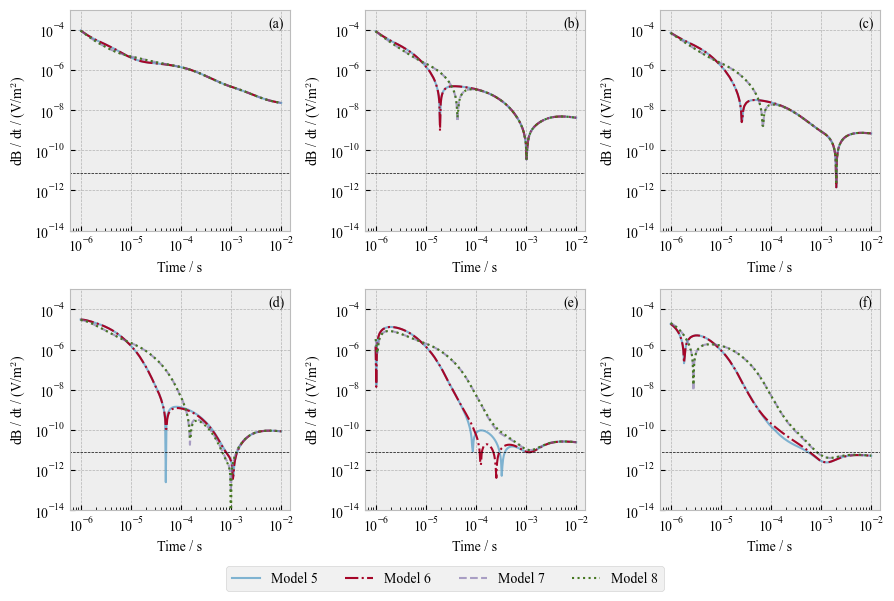

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('bmh')

mu_r = 100
sigma_air = 1e-8
sigma_half = round(1 / 300, 4)
sigma_frame = 5e5
sigma_rail  = 1.25e6
sigma_block = [sigma_half, 1]

offset = [0, 5, 10, 20, 30, 50]
dir = [1, 2, 3, 4, 5]
angle = [0, 30, 45, 60, 90, 120, 150, 180]
length = 1  # 线圈边长

times = np.logspace(np.log10(1e-6), np.log10(1e-2), 300)
line = ['-', '-.', '--', ':']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']
linestyles = ['-', ':', '--', '-.',  '-', '--']

dobs = read_data(sigma_block, dir[0], offset, angle[0], 100)
dobs200 = read_data(sigma_block, dir[0], offset, angle[0], 200)

noise_level = np.ones(times.shape[0]) * 7.5e-12

fig = plt.figure(figsize=(9, 5.8), dpi=100)
plt.rcParams["font.family"] = "Times New Roman"
font = 10
for i in range(len(offset)):
    ax = plt.subplot(2, 3, i+1)
    for j in range(len(sigma_block)):
        al = 0.6 + j * 0.4
        ax.loglog(times, np.abs(dobs[i][j]), 'C{}{}'.format(j, line[j]), lw = 1.5, label='Model {}'.format(5+j), alpha=al)
        # ax.loglog(times, np.abs(dobs200[i][j]), 'C{}{}'.format(j+2, line[j+2]), label='Model {}'.format(7+j))

    for j in range(len(sigma_block)):
        al = 0.6 + j * 0.4
        # ax.loglog(times, np.abs(dobs[i][j]), 'C{}{}'.format(j, line[j]), label='Model {}'.format(5+j))
        ax.loglog(times, np.abs(dobs200[i][j]), 'C{}{}'.format(j+2, line[j+2]), lw = 1.5, label='Model {}'.format(7+j), alpha=al)

    ax.loglog(noise_level, 'k--', lw=0.5)
    # ax.text(times[-1], 1e-10 * 0.8, f"nosie level", fontsize=font, verticalalignment='top', horizontalalignment='right')

    ax.text(0.90, 0.97, f"({chr(97+i)})", transform=ax.transAxes, fontsize=font, verticalalignment='top')
    ax.set_xlabel('Time / s', fontsize=font)
    ax.set_ylabel('dB / dt / (V/m$^2$)', fontsize=font)
    # ax.legend(loc=3, fontsize=8)
    # ax.grid(True, c="0.9")
    ax.set_ylim([1e-14, 1e-3])
    ax.set_xlim([6e-7, 1.5e-2])

# 将图例放置在图片下方
handles, labels = [], []
# for ax in fig.axes:
for handle, label in zip(*ax.get_legend_handles_labels()):
    handles.append(handle)
    labels.append(label)

fig.legend(handles, labels, loc='lower center',  bbox_to_anchor=(0.5, -0.04), ncol=6, fontsize=font)

plt.tight_layout(rect=[0, 0.01, 1, 1])  # 调整布局以给图例留出空间

plt.savefig('./figure7.eps', dpi=350, bbox_inches="tight")
plt.savefig('./figure7.png', dpi=350, bbox_inches="tight")
plt.savefig('./figure7.tiff', dpi=350, bbox_inches="tight")